In [1]:
import numpy as np
import cvxpy as cp
from scipy.io import loadmat
import pandas as pd
from network import *
import matplotlib.pyplot as plt

First, read in problem parameters. These can come from any source, but they should be reshaped into a `pandas.DataFrame` object with the format shown here

In [2]:
# System base in MVA, taken from PowerWorld. Used to convert from MW to per-unit.
base = 100

# Key/value pairs are the names and contents of the sheets in the excel model data
model_df = pd.read_excel('Example11_9_Network_Model_Jul19.xlsx', sheet_name=None)

# The initial conditions of the demand curves
load = model_df['LoadProfiles'].set_index('Date')
load.index+=pd.TimedeltaIndex(load.HE-1, unit='h')
load = load.drop(columns='HE')
demand = load.loc[:,load.columns.str.contains('Load')]/base
demand.columns = demand.columns.str.replace('Load','').astype(int)
price = load.loc[:,load.columns.str.contains('Price')]
price.columns = price.columns.str.replace('Price','').astype(int)

# Generation profiles for intermittant sources
int_gen = pd.read_excel('Normalized generation profiles.xlsx', sheet_name='Normalized', index_col=0)
int_gen.index+=pd.TimedeltaIndex(int_gen.HE-1, unit='h')
int_gen = int_gen.drop(columns='HE')
int_gen = int_gen.loc[load.index, model_df['Gen']['Type']]
int_gen = int_gen*np.array(model_df['Gen']['Installed MW'])/base
int_gen.columns = np.array(model_df['Gen']['Number of Bus'])

# Set elasticity constant, for now
epsilon = demand.copy()
epsilon[:] = -.7

voll = price.copy()
voll[:] = price*2

profile = pd.concat(
    {
        'nom_load': demand,
        'nom_price': price,
        'elasticity': epsilon,
        'voll': voll,
        'int_gen': int_gen
    },
    axis='columns'
)
transition = 0.9
profile.int_gen = transition*profile.int_gen

To create the network mode, we also need the admittance matrix, line flow limits, storage duration, and generator limits/cost coefficients, as defined below.

In [3]:
# Process Ybus matrix
Y = model_df['YBus']
Y = Y.drop(columns=['Number', 'Name'])
Y = Y.apply(lambda row: row.str.replace('j', ''))
Y = Y.apply(lambda row: row.str.replace(' ', ''))
Y = Y + 'j'
Y = Y.fillna(0)
Y = Y.applymap(complex)
Y = np.array(Y)

# Number of buses
N = Y.shape[0]

# Susceptance matrix. Recall in DC power flow, G = 0 and shunt admittances are zero.
B = np.array(np.imag(Y))
B = B - np.diag(np.diag(B))
B = B - np.diag(np.sum(B, axis=0))

# Line constraints. The i, j element is the MVA limit of the line from bus i to bus j
P_line = np.zeros((N,N))
limits = model_df['Line']
P_line[limits['From Number']-1, limits['To Number']-1] = limits['Lim A MVA']
P_line = (P_line+P_line.T)/base

# Number of timesteps to fully charge/discharge storage
b_duration = 4

# Dispatchable generator costs, in the form [linear; quadratic]
cost_coeffs = np.array(
    [
        [10,8,12],
        [.016,0.18,0.18]
    ]
)

# Generator limits
dis_max = (1-transition)*np.array(model_df['Gen']['Installed MW'])/base

Instantiate model

In [4]:
model = Network(
    B=B,
    line_lims=P_line,
    profile=profile,
    dis_max=dis_max,
    total_storage=2000/base, # make function of transition probability
    storage_cycle_timesteps=4,
    cost_coeffs=cost_coeffs,
    cycle_storage=True
)

Solve model. This will add output data to the `model.profile` dataframe as well as the following model attributes:
- `model.storage_capacity`: the storage capacity allocated to each bus
- `model.initial_charge`: the initial state-of-charge of each storage unit

In [5]:
model.solve()

Plot all the prices and their nominal values (dotted). Bus 1 has no nominal price because it does not have a load.

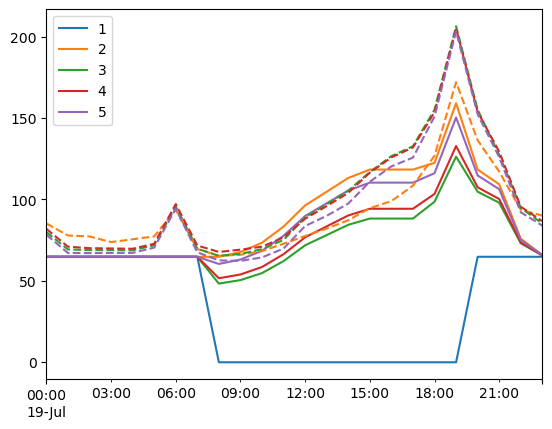

In [6]:
fig, ax = plt.subplots()
model.profile.price.plot(ax=ax)
# Save colors for consistency
colors = np.array([line.get_color() for line in ax.lines])
ax.set_prop_cycle(None)
model.profile.nom_price.plot(ax=ax,style='--',color=colors[model.profile.nom_price.columns-1],legend=False)
fig.show()

Similar idea with the loads - nominal dotted, actual solid

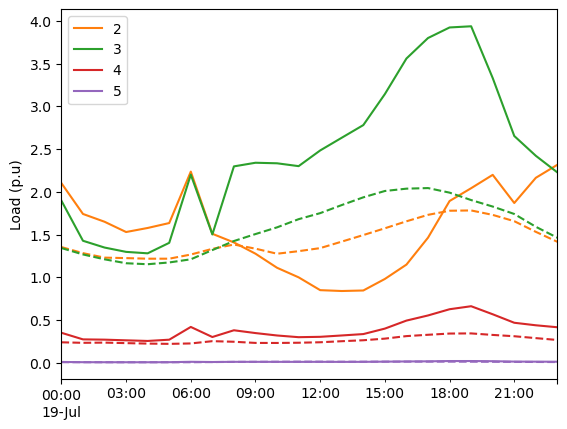

In [7]:
fig, ax = plt.subplots()
model.profile.load.plot(ax=ax,color=colors[model.profile.load.columns-1])
model.profile.nom_load.plot(ax=ax,style='--',color=colors[model.profile.load.columns-1],legend=False)
ax.set_ylabel('Load (p.u)')
fig.show()

Compute the dispatchable and intermittent (dotted) loads

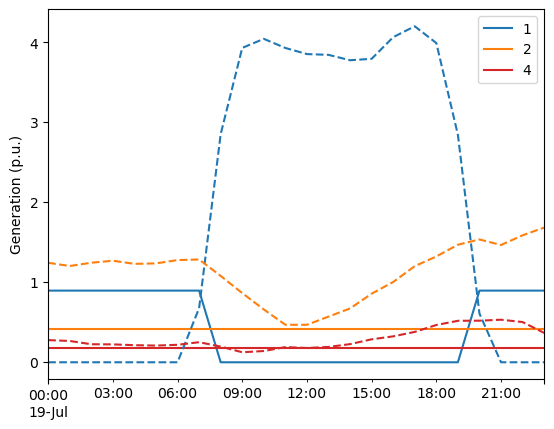

In [8]:
dispatchable = model.profile.generation - model.profile.int_gen
dispatchable[dispatchable < 0] = 0
intermittent = model.profile.generation - dispatchable

fig, ax = plt.subplots()
dispatchable.plot(ax=ax,color=colors[dispatchable.columns-1])
intermittent.plot(ax=ax,style='--',color=colors[intermittent.columns-1],legend=False)
ax.set_ylabel('Generation (p.u.)')
fig.show()

Compute producer (solid) and consumer (dashed) surplus according to:
- Consumer surplus = revenue - cost
- Producer surplus = utility - expenses

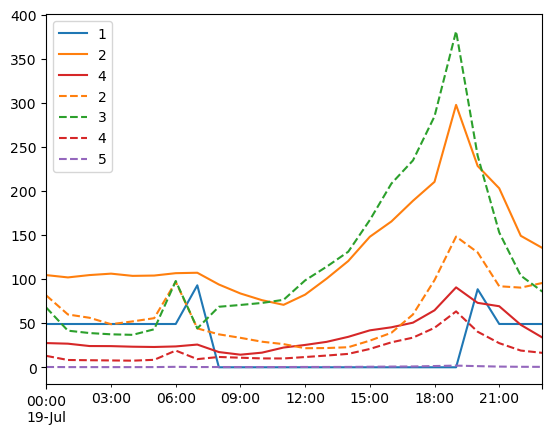

In [9]:
producer_surplus = model.profile.generation*model.profile.price[model.profile.generation.columns]-model.profile.cost
consumer_surplus = model.profile.utility - model.profile.load*model.profile.price[model.profile.load.columns]

fig, ax = plt.subplots()
producer_surplus.plot(ax=ax,color=colors[producer_surplus.columns-1])
consumer_surplus.plot(ax=ax,style='--',color=colors[consumer_surplus.columns-1])
fig.show()

Compute line loading, as a percentage. A negative value indicates power is flowing in the reverse direction with respect to the legend.

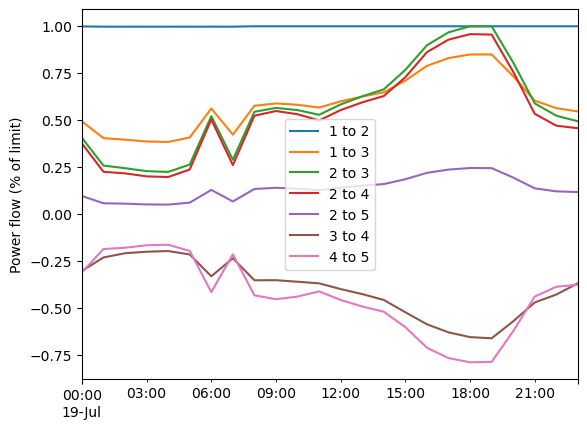

In [10]:
origin, destination = np.triu_indices(model.B.shape[0],1)
line_flows = model.profile.angle.apply(
    lambda row: pd.Series((model.B*outer_difference(row.to_numpy()))[(origin,destination)]),
    axis='columns'
)
line_flows.columns = [f'{origin[k]+1} to {destination[k]+1}' for k in range(len(line_flows.columns))]
lims = model.line_lims[(origin,destination)]
edge_idx = np.nonzero(lims)[0]
line_flows = line_flows.iloc[:,edge_idx]/lims[edge_idx]

fig, ax = plt.subplots()
line_flows.plot(ax=ax)
ax.set_ylabel('Power flow (% of limit)')
fig.show()

State-of-charge computation

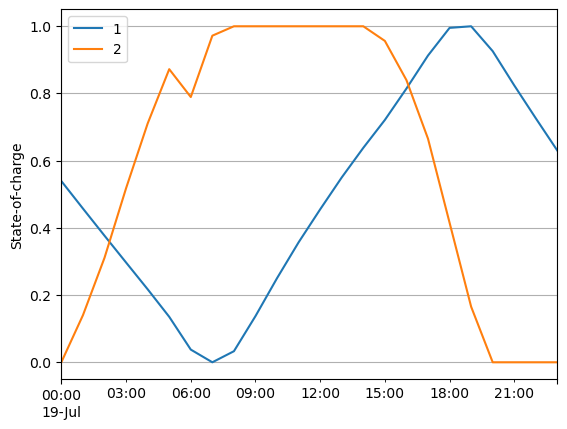

In [11]:
storage_mask = model.storage_capacity >= 1e-3
soc = model.initial_charge + model.profile.storage_load.cumsum()
soc = soc.loc[:,storage_mask]/model.storage_capacity[storage_mask]

fig, ax = plt.subplots()
soc.plot(ax=ax)
ax.set_ylabel('State-of-charge')
ax.grid()
fig.show()

Run an analysis isolating the effect of price elasticity on prices and consumer surplus

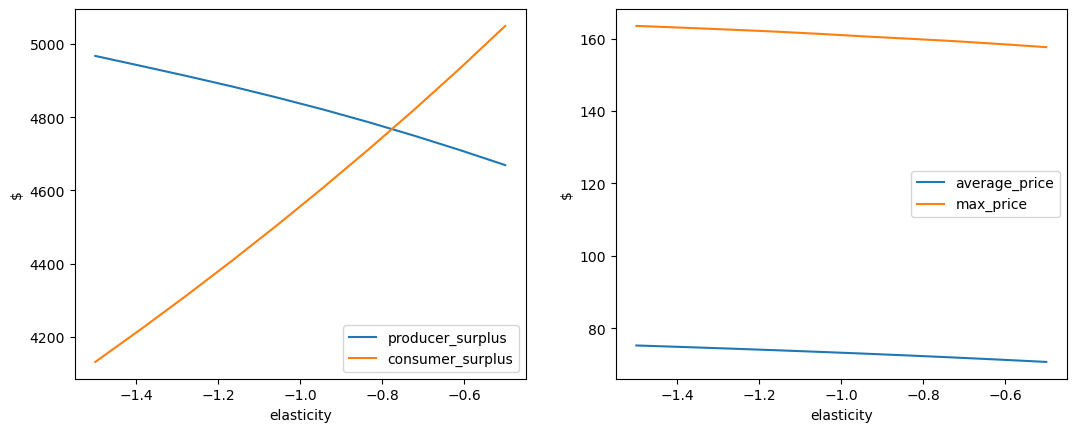

In [12]:
results = {}
for eps in np.linspace(-1.5, -.5, 10):
    model.profile.elasticity = eps
    model.solve()
    producer_surplus = model.profile.generation*model.profile.price[model.profile.generation.columns]-model.profile.cost
    consumer_surplus = model.profile.utility - model.profile.load*model.profile.price[model.profile.load.columns]
    results[eps] = pd.Series(
        {
            'producer_surplus': producer_surplus.sum().sum(),
            'consumer_surplus': consumer_surplus.sum().sum(),
            'average_price': model.profile.price.mean(axis=None),
            'max_price': model.profile.price.max(axis=None)
        }
    )
results = pd.DataFrame(results).T

fig, ax = plt.subplots(1,2)
results[['producer_surplus','consumer_surplus']].plot(ax=ax[0])
results[['average_price','max_price']].plot(ax=ax[1])
[a.set_xlabel('elasticity') for a in ax]
ax[0].set_ylabel('$')
ax[1].set_ylabel('$')
fig.set_size_inches(fig.get_size_inches()*[2,1])